#### Importation des bibliothèques

In [2]:
import nilearn.datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib

from nilearn.input_data import NiftiMasker, NiftiMapsMasker, NiftiSpheresMasker, NiftiLabelsMasker
from nilearn import plotting
from nilearn.connectome import ConnectivityMeasure
from nilearn.plotting import plot_connectome

from matplotlib.colors import LinearSegmentedColormap

#### Importation du jeu de données

In [4]:
dataset_abide = nilearn.datasets.fetch_abide_pcp(n_subjects=400)
pheno = pd.DataFrame(dataset_abide['phenotypic'])

In [5]:
#Fonction qui créé une liste contenant les individus asd et une liste contenant les individus td
def class_asd_td(pheno):
    asd = []
    td = []
    for i in range (len(pheno)):
        if pheno['DX_GROUP'].iloc[i] == 1 : 
            asd.append(i)
        else :
            td.append(i)
    return asd, td

Pour les analyses de groupe, seulement 100 individus seronts étudiés.

In [7]:
asd, td = class_asd_td(pheno[:100])

print("nombre d'individus asd :", len(asd))
print("nombre d'individus td :", len(td))

nombre d'individus asd : 50
nombre d'individus td : 50


#### Affichage de matrices de corrélation sur les séries temporelles et de connectomes pour un sujet ASD

Exemple d'affichage de matrices de corrélation pour un sujet seulement. Ces matrices de corrélation seront utilisées comme features dans la classification notamment. Il s'agit ici d'une partie d'exploration des outils, il n' y a pas de résultats à commenter. Les premières analyse de connectivité sont réalisées avec l'atlas MSDL. 

In [10]:
# Chargement de l'atlas MSDL et création d'un masque

data_dir = None
atlas_msdl_dataset = nilearn.datasets.fetch_atlas_msdl(data_dir=data_dir)
atlas_msdl_filepath = atlas_msdl_dataset.maps
labels_msdl = atlas_msdl_dataset.labels
atlas_msdl_coords = atlas_msdl_dataset.region_coords
n_regions_msdl = len(atlas_msdl_coords)

atlas_msdl_masker = NiftiMapsMasker(maps_img=atlas_msdl_filepath, standardize=True)

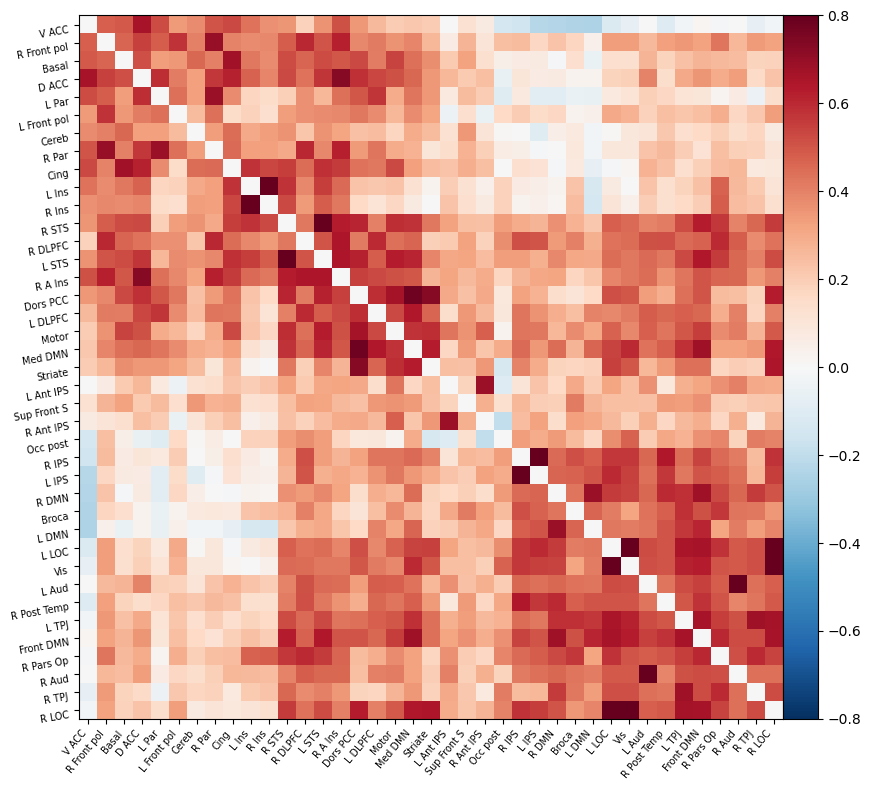

In [11]:
# Exemple d'affichage d'une matrice de corrélation sur un sujet ASD

fmri_filepath_asd0 = dataset_abide['func_preproc'][0] #individu 0
data_in_atlas_msdl = atlas_msdl_masker.fit_transform(fmri_filepath_asd0)

#Création de la matrice de corrélation

correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([data_in_atlas_msdl])[0]

# Affichage de la matrice de corrélation

np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels = labels_msdl,
                     vmax=0.8, vmin=-0.8, reorder=True)

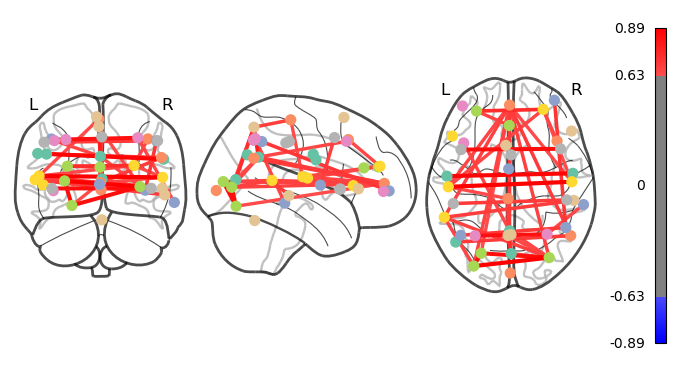

In [12]:
# Affichage des 5% des corrélations les plus élevées sur un connectome

coords = atlas_msdl_dataset.region_coords
plot_connectome(correlation_matrix, coords,
                edge_threshold="95%", colorbar=True)

#### Matrice de corrélation moyenne et connectome moyen pour chaque groupe (ASD et TD)

Création des matrices de corrélation à l'échelle des groupes (groupe ASD de 50 individus et groupe TD de 50 individus). Des différences sont visibles entre les deux groupes, mais il est difficile d'interpréter ces résultats lorsqu'on ne s'y connait pas en neurosciences. L'approche suivante basée sur un article a pour objectif de reproduire des résultats de la littérature qui sont "interprétables".

##### Application de l'atlas aux données

In [16]:
#Création du masque de l'atlas msdl

atlas_msdl_masker_bis = NiftiMapsMasker(
    atlas_msdl_filepath,
    resampling_target="data",
    t_r=2,
    detrend=True,
    low_pass=0.1,
    high_pass=0.01,
    memory="nilearn_cache",
    memory_level=1,
    standardize="zscore_sample",
    standardize_confounds="zscore_sample",
).fit()

In [17]:
#Création de deux listes avec les séries temporelles des individus ASD dans une et des individus TD dans l'autre

asd_ts = []
td_ts = []
pooled_subjects = []
groups = []  # asd or td

for subj in range (100):

    group = pheno['DX_GROUP'][subj]
    fmri_filepath = dataset_abide['func_preproc'][subj]
    
    time_series = atlas_msdl_masker_bis.transform(fmri_filepath)
    pooled_subjects.append(time_series)
    
    if group == 1:
        asd_ts.append(time_series)
    else : 
        td_ts.append(time_series)
    
    groups.append(group)

##### Matrice de corrélation moyennée pour le groupe ASD

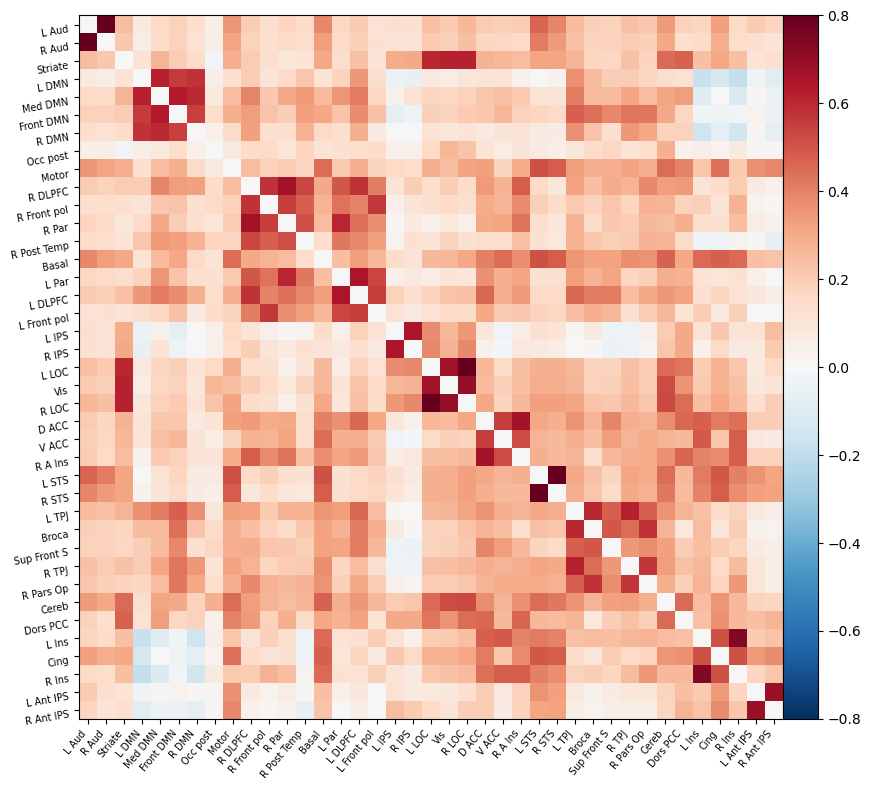

In [19]:
# Matrice de corrélation moyennée pour l'ensemble des sujets ASD

correlation_measure_asd = ConnectivityMeasure(
    kind="correlation",
    standardize="zscore_sample",
)

correlation_matrices_asd = correlation_measure_asd.fit_transform(asd_ts)
mean_correlation_matrix_asd = correlation_measure_asd.mean_

np.fill_diagonal(mean_correlation_matrix_asd, 0)
plotting.plot_matrix(mean_correlation_matrix_asd, figure=(10, 8), labels=labels_msdl,
                     vmax=0.8, vmin=-0.8, reorder=False)

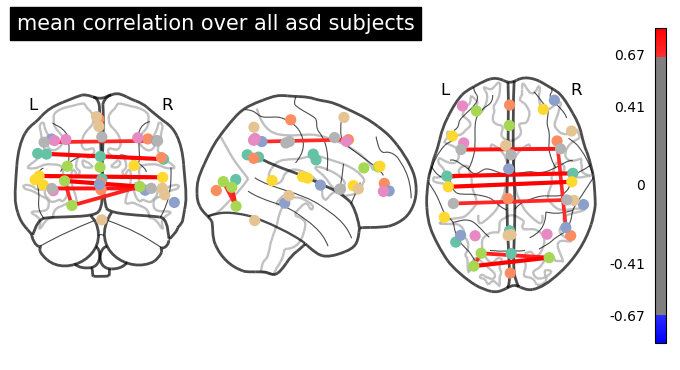

In [20]:
# Connectome moyenné pour le groupe ASD - Les 1% des corrélations les plus élevées

plotting.plot_connectome(
    mean_correlation_matrix_asd,
    atlas_msdl_coords,
    title="mean correlation over all asd subjects",
    edge_threshold = "99%",
    colorbar = True,
)

##### Matrice de corrélation moyennée pour le groupe TD

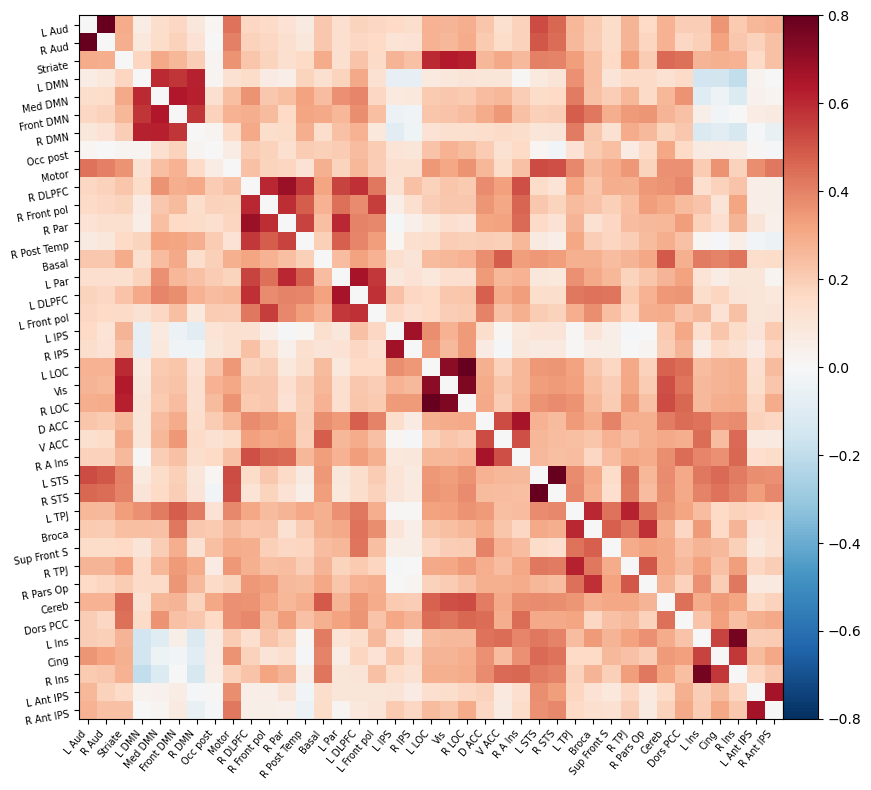

In [23]:
# Matrice de corrélation moyennée pour l'ensemble des sujets TD

correlation_measure_td = ConnectivityMeasure(
    kind="correlation",
    standardize="zscore_sample",
)

correlation_matrices_td = correlation_measure_td.fit_transform(td_ts)
mean_correlation_matrix_td = correlation_measure_td.mean_

np.fill_diagonal(mean_correlation_matrix_td, 0)
plotting.plot_matrix(mean_correlation_matrix_td, figure=(10, 8), labels=labels_msdl,
                     vmax=0.8, vmin=-0.8, reorder=False)

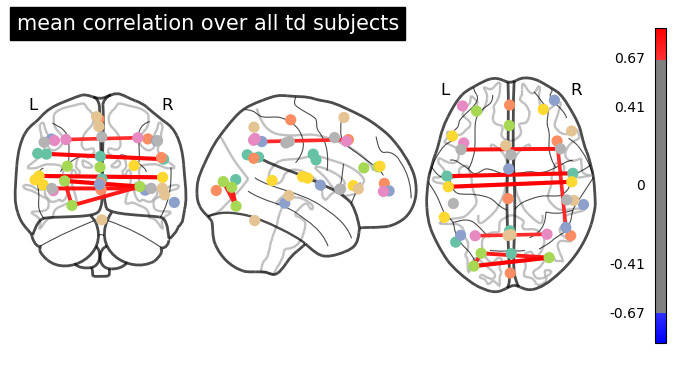

In [27]:
# Connectome moyenné pour le groupe TD - Les 1% des corrélations les plus élevées

plotting.plot_connectome(
    mean_correlation_matrix_td,
    atlas_msdl_coords,
    title="mean correlation over all td subjects",
    edge_threshold= "99%",
    colorbar= True
)

##### Différence entre les deux groupes

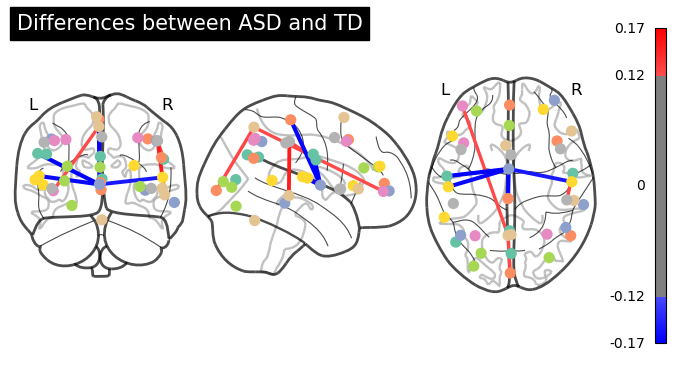

In [30]:
# Visualisation d'un connectome de différence - Visualiser les 1% des connexions fonctionnelles qui diffèrent le plus entre les deux groupes

mean_diff = mean_correlation_matrix_td - mean_correlation_matrix_asd

plotting.plot_connectome(
    mean_diff,
    atlas_msdl_coords,
    title="Differences between ASD and TD",
    edge_threshold= "99%",
    colorbar= True
)

#### Seed to voxels correlation

Cette approche est basée sur l'article d'Alaerts et al. Une graine est placée dans la région du sillon temporal supérieur postérieur (pSTS) et les corrélations dans le reste du cerveau sont observées. Plus particulièrement, la corrélation avec le lobule parietal inférieur (IPL, dont les coordonnées sont [32,-36,49]) est analysée. A l'échelle individuelle, une plus grande connectivité entre ces deux zones chez l'individu TD est observable, cela a aussi été montré dans l'article. J'ai voulu généraliser cette observation au groupe, mais les cartes obtenues n'ont pas montré de différences de connectivité entre le pSTS et l'IPL entre les deux groupes. 

##### Fonctions et coordonnées de la graine

In [34]:
# Renvoie la matrice de corrélation de la graine avec les autres voxels

def seed_to_voxel_corr(subj, brain_masker, seed_masker):
    
    #fichier
    fmri_filepath = dataset_abide['func_preproc'][subj]
    #seed masker
    #seed_masker = NiftiSpheresMasker(psts_coords,radius=10,detrend=True,standardize="zscore_sample",low_pass=0.1,high_pass=0.01,t_r=2,memory="nilearn_cache",memory_level=1,verbose=0)
    seed_time_series = seed_masker.fit_transform(fmri_filepath)
    #brain masker
    #brain_masker = NiftiMasker(smoothing_fwhm=6,detrend=True,standardize="zscore_sample",low_pass=0.1,high_pass=0.01,t_r=2,memory="nilearn_cache",memory_level=1,verbose=0)
    brain_time_series = brain_masker.fit_transform(fmri_filepath)
    #matrice de correlation
    seed_to_voxel_correlations = np.dot(brain_time_series.T, seed_time_series) / seed_time_series.shape[0]

    return seed_to_voxel_correlations

In [35]:
# Moyenner différentes images NIFTI - Fonction utilisée pour les études à l'échelle du groupe

def moyenne_images(list_images):
    
    a,b,c,d = list_images[0].get_fdata().shape
    nb_images = len(list_images)

    mean_mat = np.zeros((a,b,c,d))

    for i in range (a):
        for j in range (b):
            for k in range (c) :
                for l in range (d):
                    coeff = 0
                    for im in list_images : 
                        coeff += im.get_fdata()[i][j][k][l]
                    mean_mat [i][j][k][l] = coeff / nb_images
                    
    return nib.Nifti1Image(mean_mat, affine = list_images[0].affine)

In [36]:
psts_coords = [(47, -60, 4)]

##### Individu ASD (278)

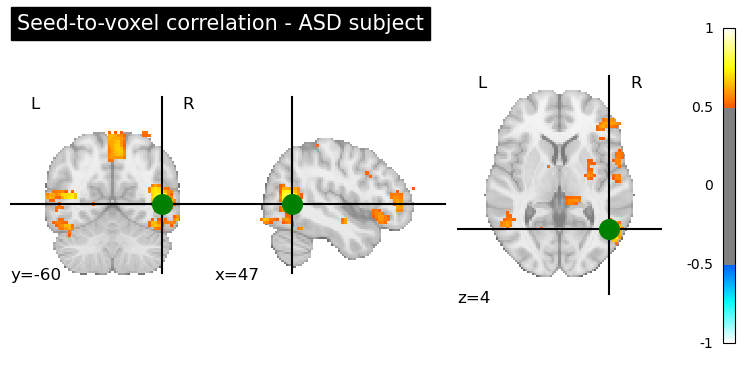

In [38]:
# Définition des masques de la graine et du cerveau
seed_masker = NiftiSpheresMasker(psts_coords,radius=10,detrend=True,standardize="zscore_sample",low_pass=0.1,high_pass=0.01,t_r=2,memory="nilearn_cache",memory_level=1,verbose=0)
brain_masker = NiftiMasker(smoothing_fwhm=6,detrend=True,standardize="zscore_sample",low_pass=0.1,high_pass=0.01,t_r=2,memory="nilearn_cache",memory_level=1,verbose=0)

# Calcul de la matrice de corrélation entre la graine et le reste du cerveau
seed_to_voxel_correlation_asd = seed_to_voxel_corr(278, brain_masker, seed_masker)

# Affichage
seed_to_voxel_correlations_img_asd = brain_masker.inverse_transform(seed_to_voxel_correlation_asd.T)
display = plotting.plot_stat_map(seed_to_voxel_correlations_img_asd,threshold=0.5,vmax=1,cut_coords=psts_coords[0],title="Seed-to-voxel correlation - ASD subject")
display.add_markers(marker_coords=psts_coords, marker_color="g", marker_size=200)

##### Individu TD (306)

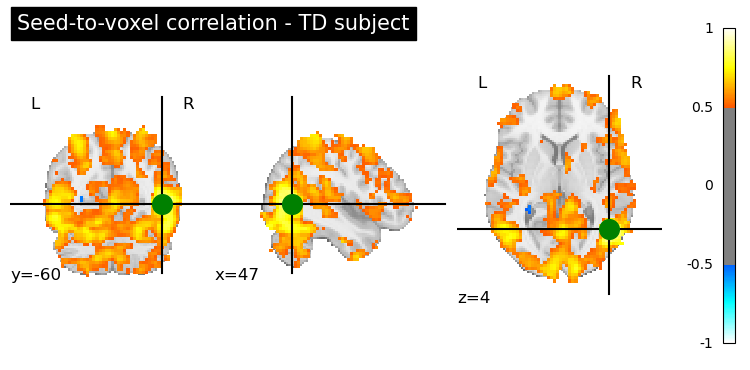

In [40]:
# Définition des masques de la graine et du cerveau
seed_masker = NiftiSpheresMasker(psts_coords,radius=10,detrend=True,standardize="zscore_sample",low_pass=0.1,high_pass=0.01,t_r=2,memory="nilearn_cache",memory_level=1,verbose=0)
brain_masker = NiftiMasker(smoothing_fwhm=6,detrend=True,standardize="zscore_sample",low_pass=0.1,high_pass=0.01,t_r=2,memory="nilearn_cache",memory_level=1,verbose=0)

# Calcul de la matrice de corrélation entre la graine et le reste du cerveau
seed_to_voxel_correlation_td = seed_to_voxel_corr(306, brain_masker, seed_masker)

# Affichage
seed_to_voxel_correlations_img_td = brain_masker.inverse_transform(seed_to_voxel_correlation_td.T)
display = plotting.plot_stat_map(seed_to_voxel_correlations_img_td,threshold=0.5,vmax=1,cut_coords=psts_coords[0],title="Seed-to-voxel correlation - TD subject")
display.add_markers(marker_coords=psts_coords, marker_color="g", marker_size=200)

##### Différence entre les deux individus (ASD 278 et TD 306)

C:\Users\elodi\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


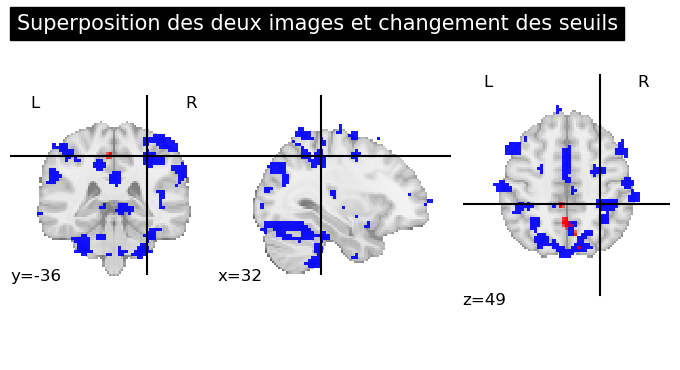

In [42]:
# Superposition des deux images 

# Affichage de la première image (TD)
display = plotting.plot_stat_map(seed_to_voxel_correlations_img_td
    , display_mode='ortho', threshold=0.6, cmap = 'blue_transparent',cut_coords=[32,-36,49], colorbar = False, 
    title = 'Superposition des deux images et changement des seuils'
)

# Superposition de la deuxième image (ASD)
display.add_overlay(seed_to_voxel_correlations_img_asd, threshold=0.6, cmap='red_transparent')

##### Groupe ASD

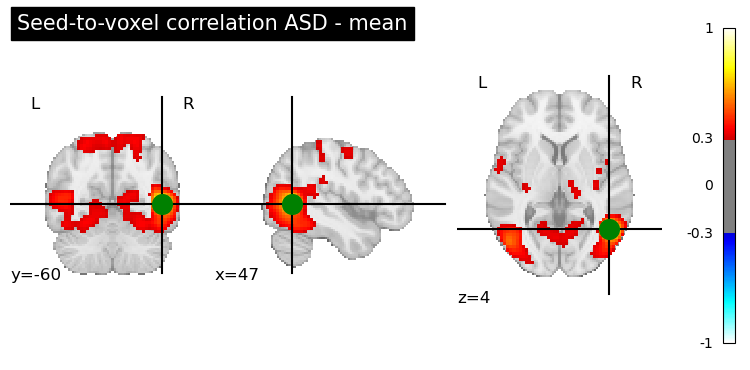

In [44]:
# Seed point correlation moyennée sur plusieurs sujets asd
liste_images_asd = []

# Définition des masques de la graine et du cerveau
seed_masker = NiftiSpheresMasker(psts_coords,radius=10,detrend=True,standardize="zscore_sample",low_pass=0.1,high_pass=0.01,t_r=2,memory="nilearn_cache",memory_level=1,verbose=0)
brain_masker = NiftiMasker(smoothing_fwhm=6,detrend=True,standardize="zscore_sample",low_pass=0.1,high_pass=0.01,t_r=2,memory="nilearn_cache",memory_level=1,verbose=0)

# Calcul des matrices de corrélation et transformation en image
for c in asd :
    
    seed_to_voxel_correlation = seed_to_voxel_corr(c, brain_masker, seed_masker)
    liste_images_asd.append(brain_masker.inverse_transform(seed_to_voxel_correlation.T))
    
# Calcul d'une image moyennée
seed_to_voxel_correlations_img_mean_asd = moyenne_images(liste_images_asd)

# Affichage
display = plotting.plot_stat_map(seed_to_voxel_correlations_img_mean_asd,threshold=0.3,vmax=1,cut_coords=psts_coords[0],title="Seed-to-voxel correlation ASD - mean")
display.add_markers(marker_coords=psts_coords, marker_color="g", marker_size=200)

C:\Users\elodi\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



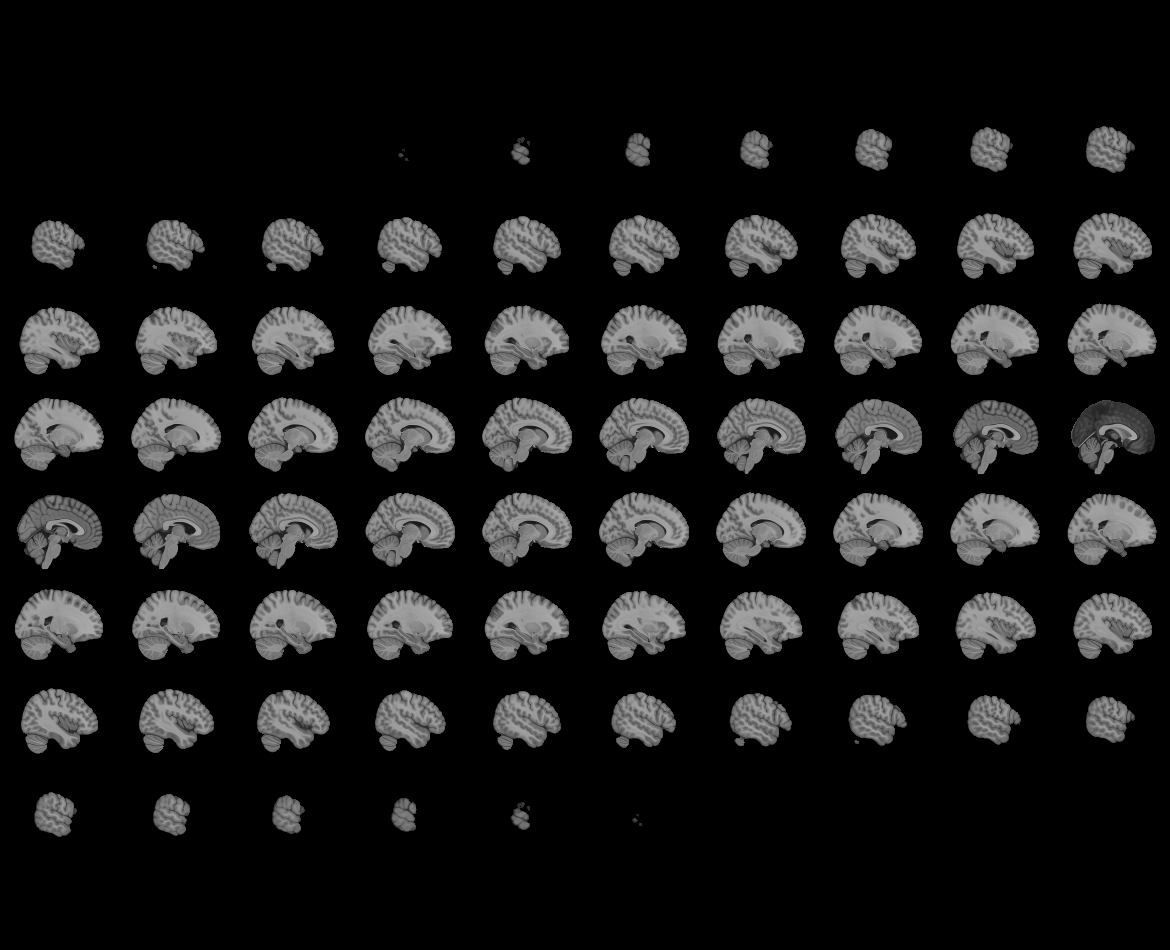
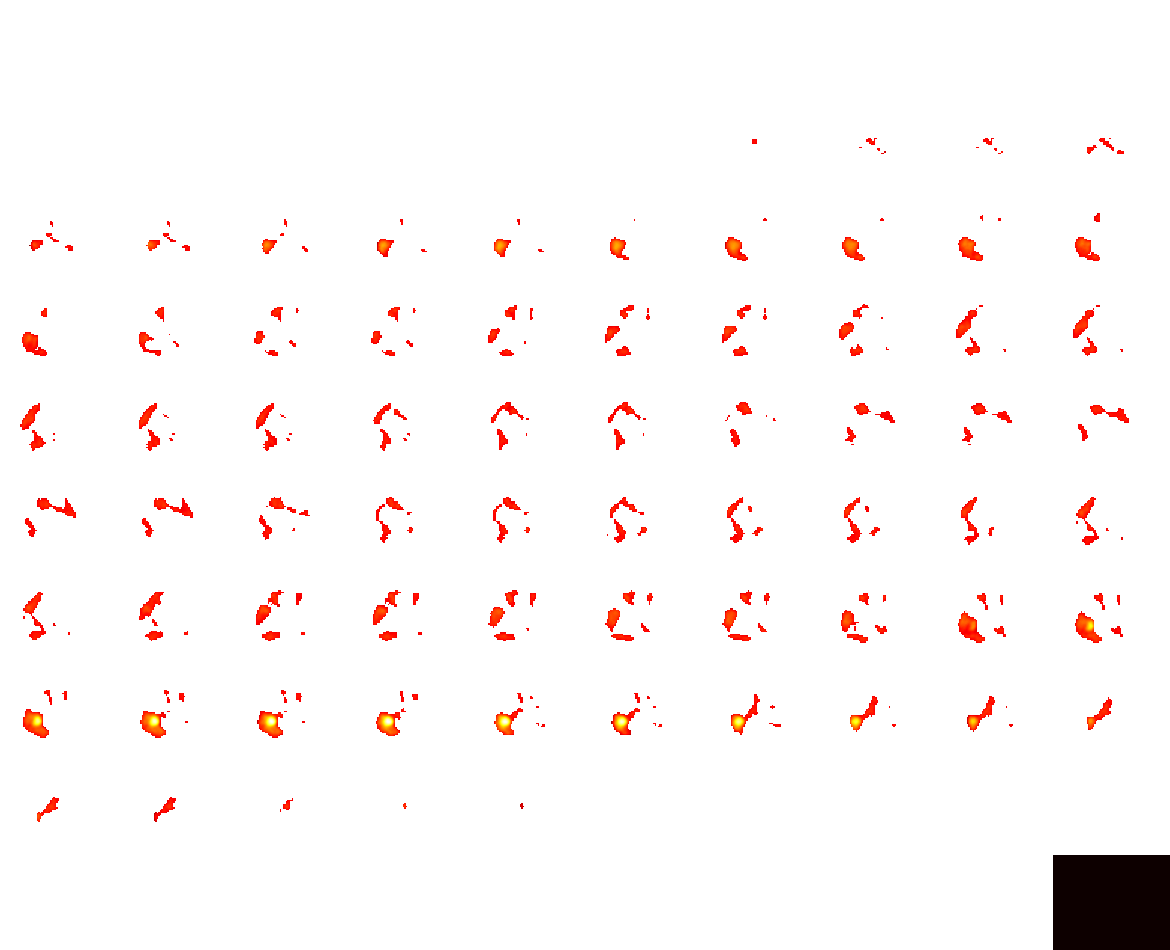

In [45]:
#Visualisation en 3D

plotting.view_img(seed_to_voxel_correlations_img_mean_asd, threshold=0.3,
                              cut_coords=[59, -21, 37],
                              title="ASD Group")

##### Groupe TD

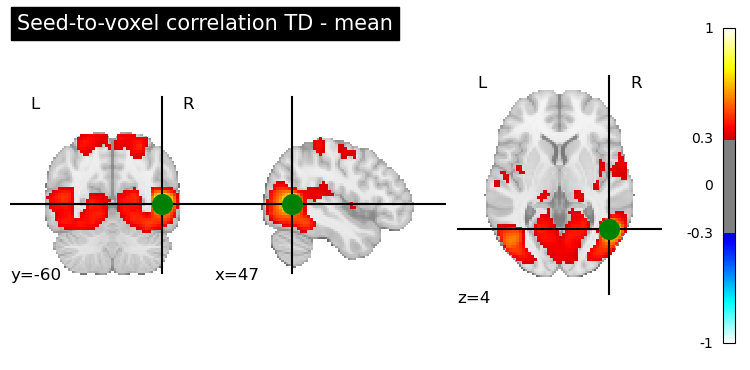

In [47]:
# Seed point correlation moyennée sur plusieurs sujets td
liste_images_td = []

# Définition des masques de la graine et du cerveau
seed_masker = NiftiSpheresMasker(psts_coords,radius=10,detrend=True,standardize="zscore_sample",low_pass=0.1,high_pass=0.01,t_r=2,memory="nilearn_cache",memory_level=1,verbose=0)
brain_masker = NiftiMasker(smoothing_fwhm=6,detrend=True,standardize="zscore_sample",low_pass=0.1,high_pass=0.01,t_r=2,memory="nilearn_cache",memory_level=1,verbose=0)

# Calcul des matrices de corrélation et transformation en image
for c in td :

    seed_to_voxel_correlation = seed_to_voxel_corr(c, brain_masker, seed_masker)
    liste_images_td.append(brain_masker.inverse_transform(seed_to_voxel_correlation.T))

# Calcul d'une image moyennée
seed_to_voxel_correlations_img_mean_td = moyenne_images(liste_images_td)

# Affichage
display = plotting.plot_stat_map(seed_to_voxel_correlations_img_mean_td,threshold=0.3,vmax=1,cut_coords=psts_coords[0],title="Seed-to-voxel correlation TD - mean")
display.add_markers(marker_coords=psts_coords, marker_color="g", marker_size=200)

C:\Users\elodi\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



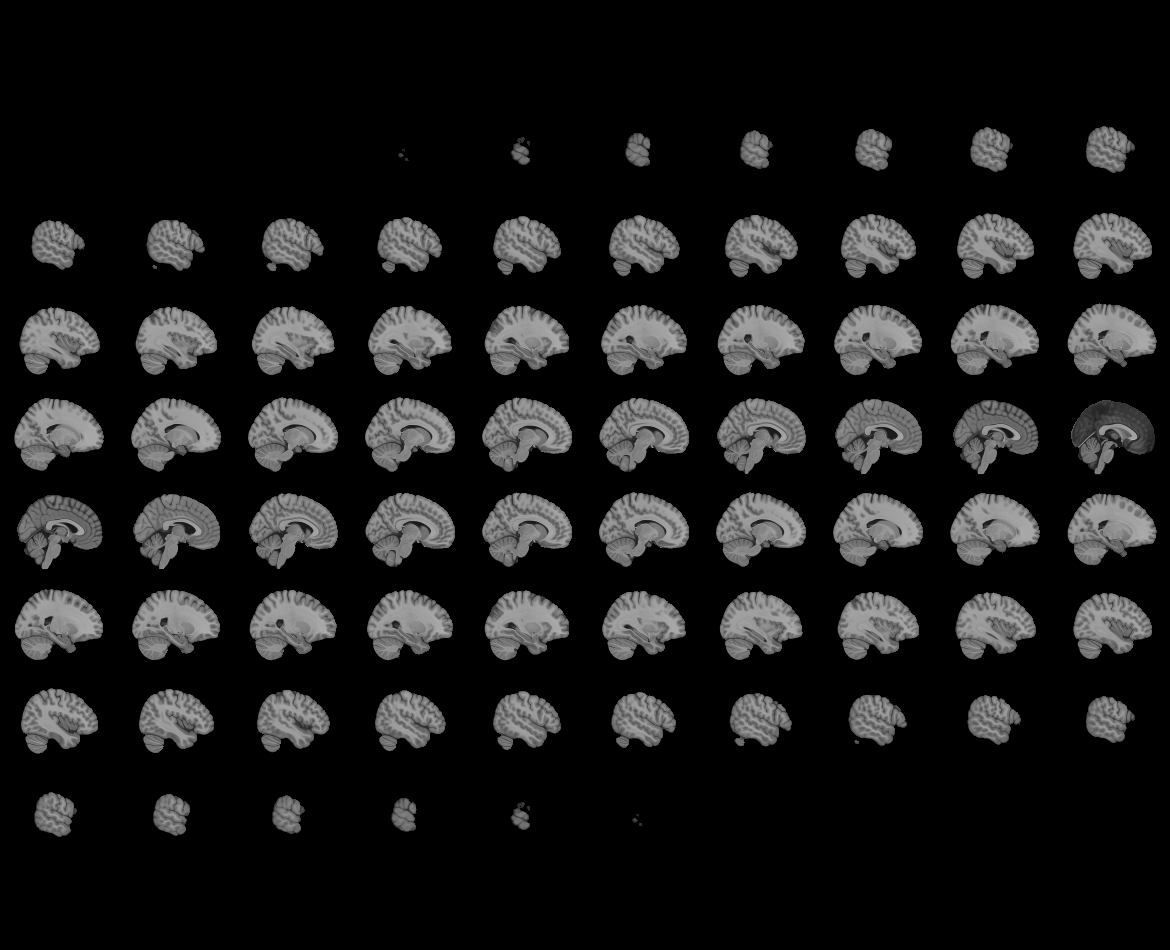
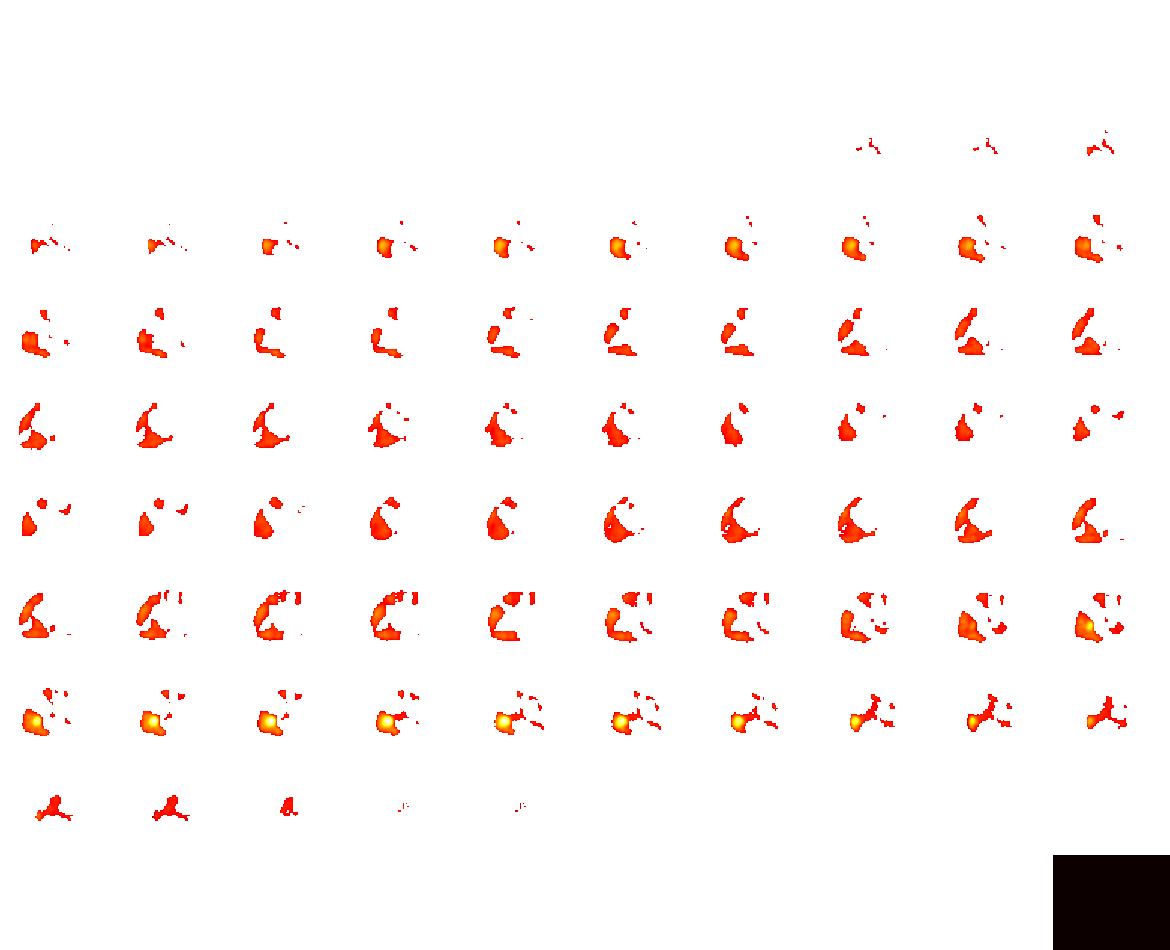

In [48]:
#Visualisation en 3D 

plotting.view_img(seed_to_voxel_correlations_img_mean_td, threshold = 0.3,
                              cut_coords=[59, -21, 37],
                              title="TD Group")

##### Différence entre les groupes ASD et TD

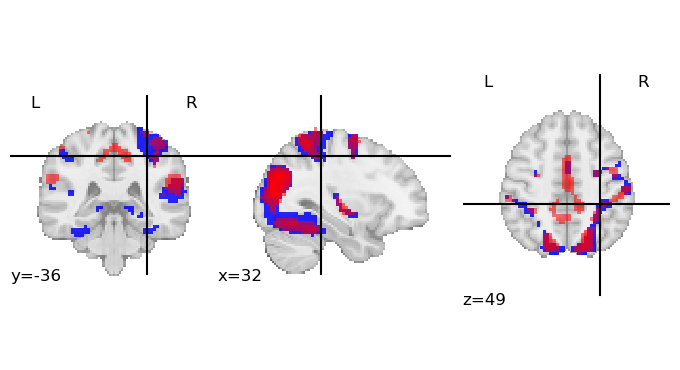

In [50]:
# Superposition des deux images 

# Affichage de la première image (TD)
display = plotting.plot_stat_map(seed_to_voxel_correlations_img_mean_td
    , display_mode='ortho', threshold=0.3, cmap = 'blue_transparent',cut_coords=[32,-36,49], colorbar = False
)

# Superposition de la deuxième image (ASD)
display.add_overlay(seed_to_voxel_correlations_img_mean_asd, threshold=0.3, cmap='red_transparent')

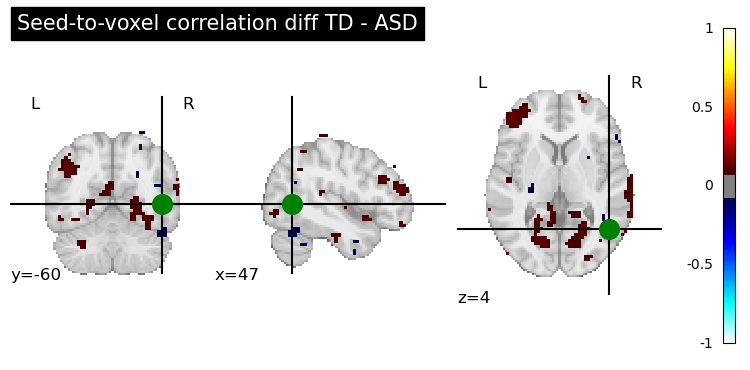

In [51]:
# Différence entre les deux images seed point correlation TD - ASD, visualisation 2D

affine_im = seed_to_voxel_correlations_img_mean_td.affine
mat_diff = seed_to_voxel_correlations_img_mean_td.get_fdata() - seed_to_voxel_correlations_img_mean_asd.get_fdata()
image_diff = nib.Nifti1Image(mat_diff, affine = affine_im)

display = plotting.plot_stat_map(image_diff, threshold = 0.08, vmax=1,cut_coords=psts_coords[0],title="Seed-to-voxel correlation diff TD - ASD")
display.add_markers(marker_coords=psts_coords, marker_color="g", marker_size=200)

C:\Users\elodi\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



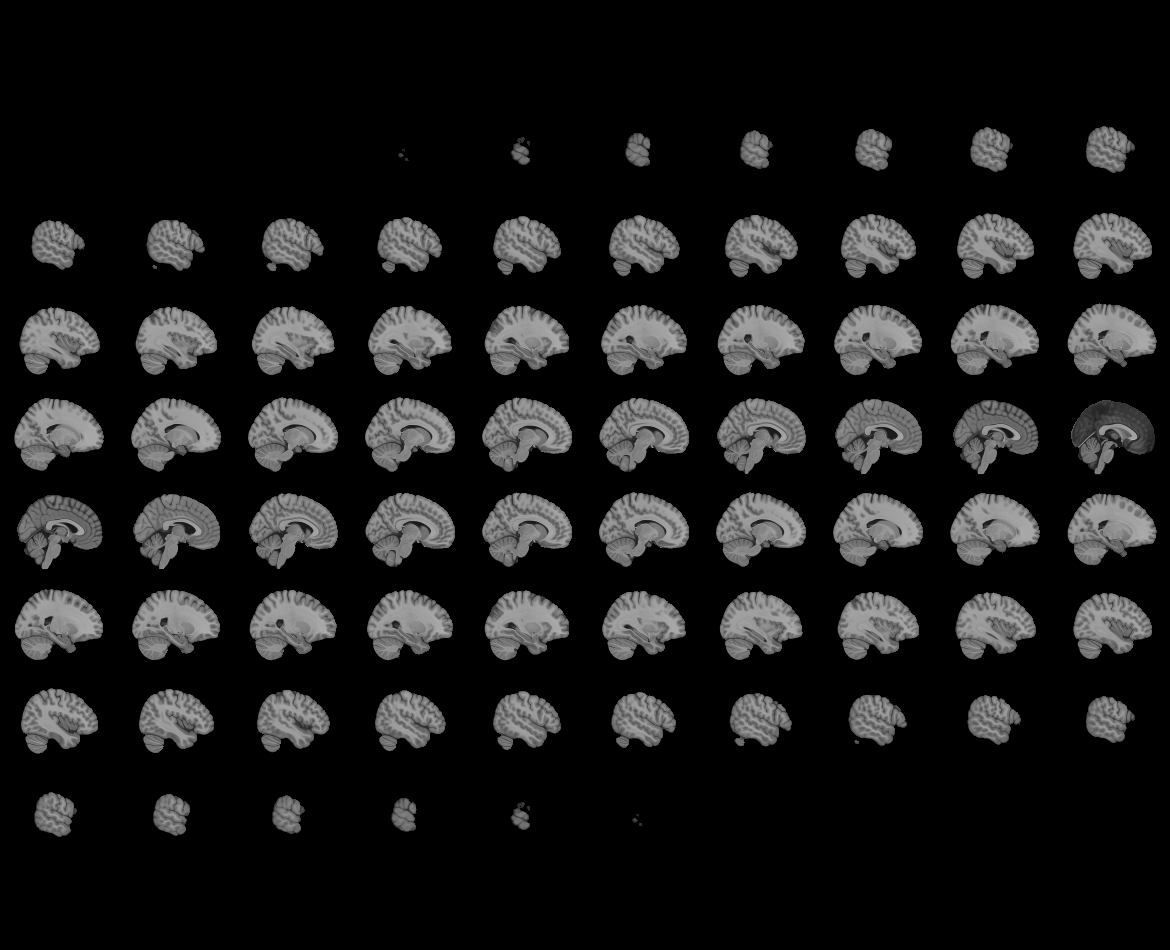
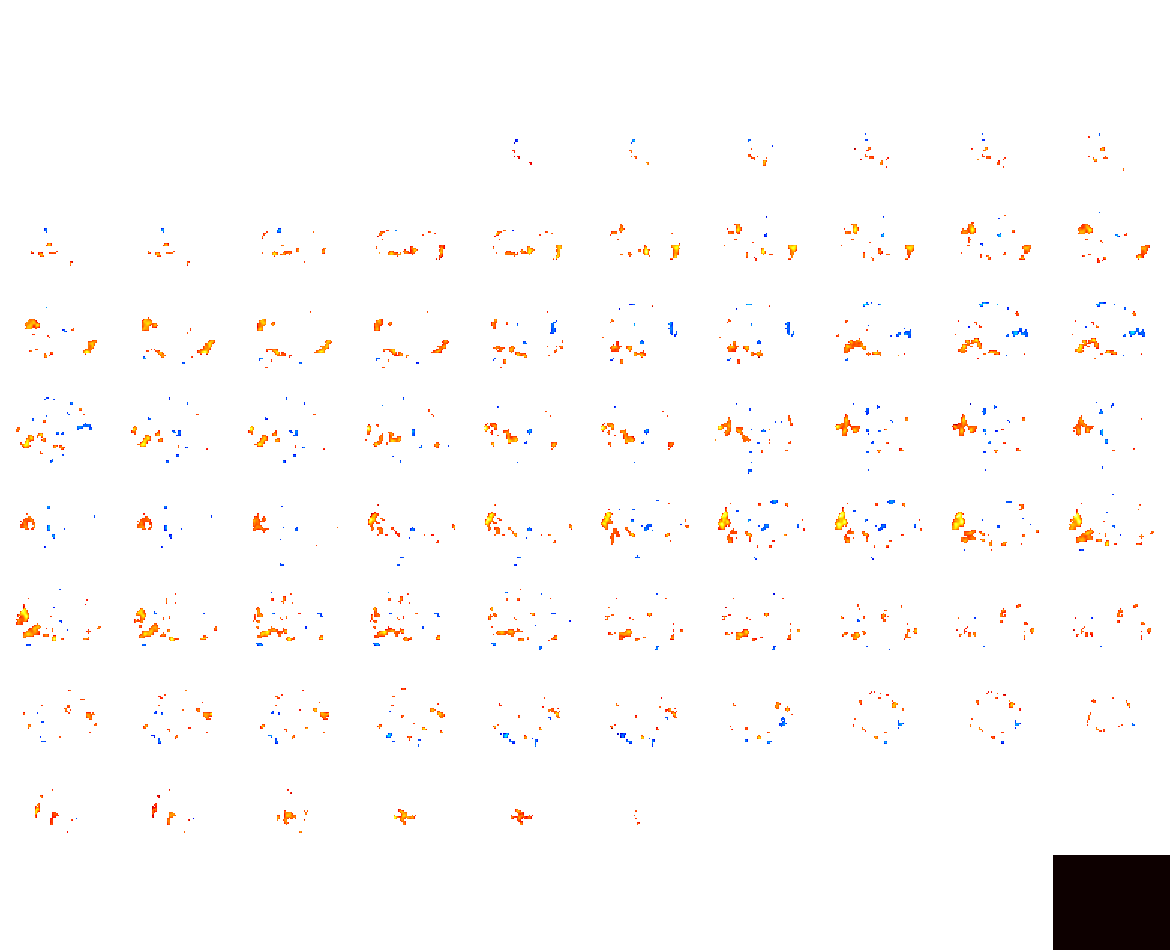

In [52]:
#Visualisation en 3D de la matrice de différences

plotting.view_img(image_diff, threshold=0.08,
                              cut_coords=[47, -60, 4],
                              title="Seed-to-voxel correlation diff TD - ASD")